# Importing Modules

In [10]:
from kafka import KafkaConsumer
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # for data visualization purposes
import seaborn as sns # for statistical data visualization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.ensemble import RandomForestClassifier

# Initializing consumer and arrays

In [11]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

Static_accuracy_array=[]
dynamic_accuracy_array=[]  
Static_predicted_array=[]
Dynamic_predicted_array=[]

# Iterator which takes a window of 1000

In [12]:
for iteration in range(1,10):   # number of windows
    print('This is window ',iteration) 
    Consumer_iteration=[]
    Loop_number=0
    empty_Arr=[]
    df2=pd.DataFrame(columns=['timestamp','FQDN_count','subdomain_length','upper','lower','numeric','entropy','special','labels','labels_max','labels_average','longest_word','sld','len','subdomain','Target Attack']) # initializing dataframe
    df2.drop(df2.index, inplace=True)
    for Consumer_record in consumer:
        if(Loop_number>((iteration*1000)+100) and Loop_number <= ((iteration+1)*1000)+100):
            Consumer_iteration.append(Consumer_record)
        # making a window of 1000
        if(Loop_number==((iteration+1)*1000)+100): 
            break
        Loop_number=Loop_number+1
    # Clening and appending the data
    for Loop_number in range(0,1000): 
        Data_line=(Consumer_iteration[Loop_number][6]).decode("utf-8")
        Data_line=Data_line[2:-3]
        Data_line=Data_line.split(",")
        empty_Arr.append(Data_line)
    for Loop_number in range(0,len(empty_Arr)):
        df2 = df2.append(pd.Series(empty_Arr[Loop_number], index=['timestamp','FQDN_count','subdomain_length','upper','lower','numeric','entropy','special','labels','labels_max','labels_average','longest_word','sld','len','subdomain','Target Attack']), 
            ignore_index=True)
    # Extracting the features and making the dataset
    fh = FeatureHasher(n_features=3, input_type='string')
    hashed1 = fh.transform(df2[['timestamp']].astype(str).values)
    hashed1 = pd.DataFrame(hashed1.todense())
    hashed1.columns = ['timestamp_fh'+str(i) for i in hashed1.columns]
    hashed2 = fh.transform(df2[['longest_word']].astype(str).values)
    hashed2 = pd.DataFrame(hashed2.todense())
    hashed2.columns = ['longest_word_fh'+str(i) for i in hashed2.columns]
    hashed3 = fh.transform(df2[['sld']].astype(str).values)
    hashed3 = pd.DataFrame(hashed3.todense())
    hashed3.columns = ['sld_fh'+str(i) for i in hashed3.columns]
    df_1 = pd.concat([df2,hashed1,hashed2,hashed3],axis=1)
    X =df_1.drop(["timestamp", "longest_word", "sld", "Target Attack"], axis = 1)
    y = df2["Target Attack"]
    y=y.astype(float)

    #choose best features for training
    train_labels = X[['subdomain_length', 'lower', 'numeric', 'special', 'labels_max', 'len',
        'longest_word_fh0', 'longest_word_fh1', 'sld_fh0', 'sld_fh1',
        'sld_fh2']]
    train_labels = train_labels.astype(float)
    X_train, X_test, y_train, y_test = train_test_split(train_labels,y ,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)
    
    filename_Static = 'model_static.sav'

    #Loading the Static model
    Static_model = pickle.load(open(filename_Static, 'rb'))
    Static_result = Static_model.score(X_test, y_test)
    Static_accuracy_array.append(Static_result)
    Static_predicted=Static_model.predict(X_test)
    Static_predicted_array.append(Static_predicted)
    print('Static accuracy',Static_result)

    
    filename_Dynamic = 'model_dynamic.sav'
    #making the dynamic model 
    Dynamic_model = RandomForestClassifier(n_estimators=300)
    Dynamic_model.fit(X_train, y_train)
    Dynamic_predicted = Dynamic_model.predict(X_test)
    Dynamic_result=Dynamic_model.score(X_test,y_test)
    dynamic_accuracy_array.append(Dynamic_result)
    Dynamic_predicted_array.append(Dynamic_predicted)
    print('dynamic_accuracy',Dynamic_result)

    # Saving the model if the accuracy is better than the Static model
    if(Dynamic_result>Static_result):
        filename = filename_Dynamic
        pickle.dump(Dynamic_model, open(filename, 'wb'))
    
    

    
print("Static accuracies ",Static_accuracy_array)
print("dynamic accuracies ",dynamic_accuracy_array)
    

This is window  1
Static accuracy 0.89
dynamic_accuracy 0.885
This is window  2
Static accuracy 0.84
dynamic_accuracy 0.84
This is window  3
Static accuracy 0.86
dynamic_accuracy 0.85
This is window  4
Static accuracy 0.86
dynamic_accuracy 0.855
This is window  5
Static accuracy 0.86
dynamic_accuracy 0.86
This is window  6
Static accuracy 0.81
dynamic_accuracy 0.805
This is window  7
Static accuracy 0.82
dynamic_accuracy 0.82
This is window  8
Static accuracy 0.825
dynamic_accuracy 0.825
This is window  9
Static accuracy 0.785
dynamic_accuracy 0.785
Static accuracies  [0.89, 0.84, 0.86, 0.86, 0.86, 0.81, 0.82, 0.825, 0.785]
dynamic accuracies  [0.885, 0.84, 0.85, 0.855, 0.86, 0.805, 0.82, 0.825, 0.785]


# Metrics Evaluation

## Plotting Graphs of accuracies

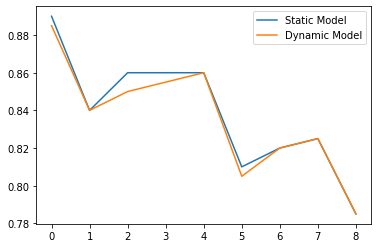

In [13]:
plt.plot(Static_accuracy_array, label = "Static Model")
plt.plot(dynamic_accuracy_array,label = "Dynamic Model")
plt.legend()
plt.show()

## Precision, Recall, Fscore, support of best dynamic model and static model

### Dynamic Model

In [14]:
from sklearn.metrics import precision_recall_fscore_support as score
# saving Precision, Recall, Fscore of the best model
precision, recall, fscore, support = score(y_test, Dynamic_predicted_array[dynamic_accuracy_array.index(max(dynamic_accuracy_array))])

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.453125   0.51470588]
recall: [0.30526316 0.66666667]
fscore: [0.36477987 0.58091286]
support: [ 95 105]


### Static Model

In [15]:
precision, recall, fscore, support = score(y_test, Static_predicted_array[Static_accuracy_array.index(max(Static_accuracy_array))])

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.44262295 0.51079137]
recall: [0.28421053 0.67619048]
fscore: [0.34615385 0.58196721]
support: [ 95 105]


# Plotting Confusion Matrix of best models

In [16]:
def conf_matrix(y_test, pred,title):
  cm = confusion_matrix(y_test, pred)
  plt.figure(figsize=(15,10))
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['Negative','Positive']
  plt.title(title)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]
  
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
  plt.show()

### Best Dynamic model

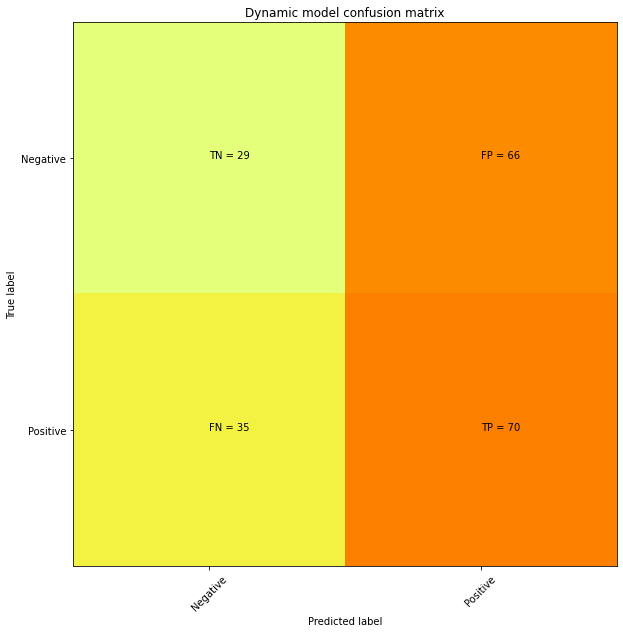

In [17]:
conf_matrix(y_test,Dynamic_predicted_array[dynamic_accuracy_array.index(max(dynamic_accuracy_array))],'Dynamic model confusion matrix')

### Best window for Static model

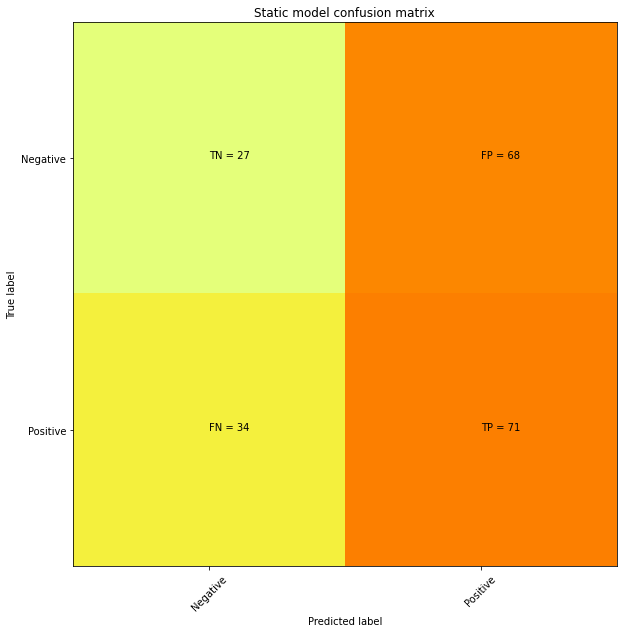

In [18]:
conf_matrix(y_test,Static_predicted_array[Static_accuracy_array.index(max(Static_accuracy_array))],'Static model confusion matrix')